In [7]:
# !pip install --upgrade pip
# !pip install --upgrade torch torchvision

In [8]:
# !wget "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar" -P ~/work/data_augmentation/data
# !tar -xf ~/work/data_augmentation/data/images.tar -C ~/work/data_augmentation/data/

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import random
import random

In [2]:
# GPU 확인
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [ ]:
dataset_dir = "~/work/data_augmentation/data/Images/"

# 기본 ImageFolder (Transform은 아래 함수에서 처리)
full_dataset = ImageFolder(root=dataset_dir)
class_names = full_dataset.classes
num_classes = len(class_names)

print(f"총 클래스 개수: {len(class_names)}")
print(f"첫 5개 클래스 예시: {class_names[:5]}")


총 클래스 개수: 120
첫 5개 클래스 예시: ['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu']


In [4]:
total_size = len(full_dataset)
train_size = int(0.583 * total_size)
test_size = total_size - train_size
ds_train_raw, ds_test_raw = random_split(full_dataset, [train_size, test_size])

In [5]:
# 분할된 인덱스 집합 생성
train_indices = set(ds_train_raw.indices)
test_indices = set(ds_test_raw.indices)

# 교집합(중복) 확인
duplicates = train_indices.intersection(test_indices)

print(f"훈련 데이터 개수: {len(train_indices)}")
print(f"테스트 데이터 개수: {len(test_indices)}")
print(f"중복된 인덱스 개수: {len(duplicates)}")

if len(duplicates) == 0:
    print("결과: 인덱스 수준에서 중복이 전혀 없습니다.")
else:
    print(f"경고: {len(duplicates)}개의 인덱스가 중복되었습니다.")

훈련 데이터 개수: 11998
테스트 데이터 개수: 8582
중복된 인덱스 개수: 0
결과: 인덱스 수준에서 중복이 전혀 없습니다.


In [6]:
def show_random_samples(dataset, class_names, num_samples=5):
    """
    데이터셋 타입(Raw PIL 또는 Processed Tensor)에 상관없이 
    랜덤하게 num_samples만큼 이미지를 출력합니다.
    """
    plt.figure(figsize=(18, 5))
    
    if isinstance(dataset, list):
        # 첫 번째 배치에서 랜덤하게 선택
        images, labels = dataset[0] 
        max_idx = len(images)
        indices = random.sample(range(max_idx), min(num_samples, max_idx))
        
        for i, idx in enumerate(indices):
            # Tensor (C, H, W) -> Numpy (H, W, C)
            img = images[idx].permute(1, 2, 0).cpu().numpy()
            # 역정규화 및 클리핑
            img = (img * 0.5) + 0.5
            img = np.clip(img, 0, 1)
            
            # 원-핫 라벨인 경우 인덱스로 변환
            lbl_data = labels[idx]
            lbl_idx = lbl_data.argmax().item() if lbl_data.dim() > 0 else int(lbl_data.item())
            
            plt.subplot(1, num_samples, i+1)
            plt.imshow(img)
            plt.title(f"Tensor: {class_names[lbl_idx].split('-')[-1]}", fontsize=10)
            plt.axis('off')
            
    else:
        max_idx = len(dataset)
        indices = random.sample(range(max_idx), min(num_samples, max_idx))
        
        for i, idx in enumerate(indices):
            img, lbl = dataset[idx] # PIL Image, int label
            
            plt.subplot(1, num_samples, i+1)
            plt.imshow(img)
            plt.title(f"PIL: {class_names[lbl].split('-')[-1]}", fontsize=10)
            plt.axis('off')
            
    plt.tight_layout()
    plt.show()

In [7]:
def normalize_and_resize_img(image, label):
    """PIL 이미지를 받아 리사이즈 및 정규화된 텐서 반환"""
    t = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    return t(image), label

In [8]:
def augment(image, label):
    """증강용: 0~1 사이의 텐서에 적용해야 clamp가 정상 작동함"""
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2)
    ])
    return transform(image), label

In [9]:
def onehot(label, num_classes=120):
    if not isinstance(label, torch.Tensor):
        label = torch.tensor(label)
    return F.one_hot(label, num_classes=num_classes).float()

In [10]:
def get_clip_box(image_shape):
    h, w = image_shape[1], image_shape[2]
    
    # 1. 박스의 중심점 (x, y)를 랜덤하게 선택
    x = torch.randint(0, w, (1,)).item()
    y = torch.randint(0, h, (1,)).item()
    
    # 2. 박스 크기 비율 결정 (하나의 비율을 공유)
    cut_rat = torch.sqrt(1. - torch.rand(1)).item()
    cut_w = int(w * cut_rat)
    cut_h = int(h * cut_rat)

    # 3. 좌표 계산 및 클램핑 (0 ~ w/h 범위로 제한)
    x_min = max(0, x - cut_w // 2)
    y_min = max(0, y - cut_h // 2)
    x_max = min(w, x + cut_w // 2)
    y_max = min(h, y + cut_h // 2)

    return x_min, y_min, x_max, y_max

In [11]:
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    # image_a의 복사본을 만들고 그 위에 image_b의 영역을 덮어씌웁니다.
    mixed_img = image_a.clone()
    mixed_img[:, y_min:y_max, x_min:x_max] = image_b[:, y_min:y_max, x_min:x_max]
    return mixed_img

In [12]:
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, img_size, num_classes):
    # 면적 비율 계산
    mixed_area = (x_max - x_min) * (y_max - y_min)
    total_area = img_size * img_size
    ratio = mixed_area / total_area

    # 원-핫 벡터 변환 (이미 원-핫인 경우를 대비해 처리)
    if label_a.ndim == 0 or label_a.size(0) != num_classes:
        label_a = F.one_hot(label_a.to(torch.int64), num_classes=num_classes).float()
    if label_b.ndim == 0 or label_b.size(0) != num_classes:
        label_b = F.one_hot(label_b.to(torch.int64), num_classes=num_classes).float()

    # 원본(1-ratio)과 삽입된 이미지(ratio)의 비중 합산
    mixed_label = (1 - ratio) * label_a + ratio * label_b
    return mixed_label

In [13]:
def cutmix(images, labels, prob=1.0, img_size=224, num_classes=120):
    current_batch_size = images.size(0) 

    mixed_imgs = []
    mixed_labels = []

    for i in range(current_batch_size):
        image_a, label_a = images[i], labels[i]
        
        # 확률(prob)에 따라 섞을지 결정
        if torch.rand(1).item() < prob:
            j = torch.randint(0, current_batch_size, (1,)).item()
            image_b, label_b = images[j], labels[j]

            x_min, y_min, x_max, y_max = get_clip_box(image_a.shape)

            mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
            mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, img_size, num_classes))
        else:
            # 섞지 않는 경우 그대로 추가 (단, 라벨은 원-핫으로 통일)
            mixed_imgs.append(image_a)
            mixed_labels.append(F.one_hot(label_a.to(torch.int64), num_classes=num_classes).float())

    mixed_imgs = torch.stack(mixed_imgs)
    mixed_labels = torch.stack(mixed_labels)

    return mixed_imgs, mixed_labels

In [14]:
def mixup_2_images(image_a, image_b, label_a, label_b, num_classes=120):
    ratio = torch.rand(1).item()

    if not isinstance(label_a, torch.Tensor) or label_a.ndim == 0:
        label_a = F.one_hot(torch.tensor(label_a).to(torch.int64), num_classes=num_classes).float()
    if not isinstance(label_b, torch.Tensor) or label_b.ndim == 0:
        label_b = F.one_hot(torch.tensor(label_b).to(torch.int64), num_classes=num_classes).float()
    mixed_image = (1 - ratio) * image_a + ratio * image_b
    mixed_label = (1 - ratio) * label_a + ratio * label_b

    return mixed_image, mixed_label

In [15]:
def mixup(images, labels, img_size=224, num_classes=120):
    current_batch_size = images.size(0) 
    
    mixed_imgs = []
    mixed_labels = []

    for i in range(current_batch_size): 
        image_a, label_a = images[i], labels[i]

        j = torch.randint(0, current_batch_size, (1,)).item()
        image_b, label_b = images[j], labels[j]

        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b, num_classes)

        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = torch.stack(mixed_imgs).view(current_batch_size, 3, img_size, img_size)
    mixed_labels = torch.stack(mixed_labels).view(current_batch_size, num_classes)

    return mixed_imgs, mixed_labels

In [16]:
def apply_normalize_on_dataset(dataset, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    # 원본 리스트에서 변환 적용
    data_list = []
    for img, lbl in dataset:
        if not is_test and with_aug:
            img, lbl = augment(img, lbl)
        img_t, lbl_t = normalize_and_resize_img(img, lbl)
        data_list.append((img_t, lbl_t))

    dataloader = DataLoader(data_list, batch_size=batch_size, shuffle=not is_test)
    
    processed_batches = []
    for imgs, lbls in dataloader:
        lbls_oh = onehot(lbls, num_classes=num_classes)
        if not is_test and with_cutmix:
            imgs, lbls_oh = cutmix(imgs, lbls_oh)
        elif not is_test and with_mixup:
            imgs, lbls_oh = mixup(imgs, lbls_oh)
        processed_batches.append((imgs, lbls_oh))
    
    return processed_batches

In [17]:
ds_test = apply_normalize_on_dataset(ds_test_raw, is_test=True)

In [18]:
ds_no_aug = apply_normalize_on_dataset(ds_train_raw, with_aug=False)

In [19]:
ds_aug = apply_normalize_on_dataset(ds_train_raw, with_aug=True)

In [20]:
ds_mixup = apply_normalize_on_dataset(ds_train_raw, with_mixup=True)

In [21]:
ds_cutmix = apply_normalize_on_dataset(ds_train_raw, with_cutmix=True)

Checking Raw Dataset (ds_train_raw):


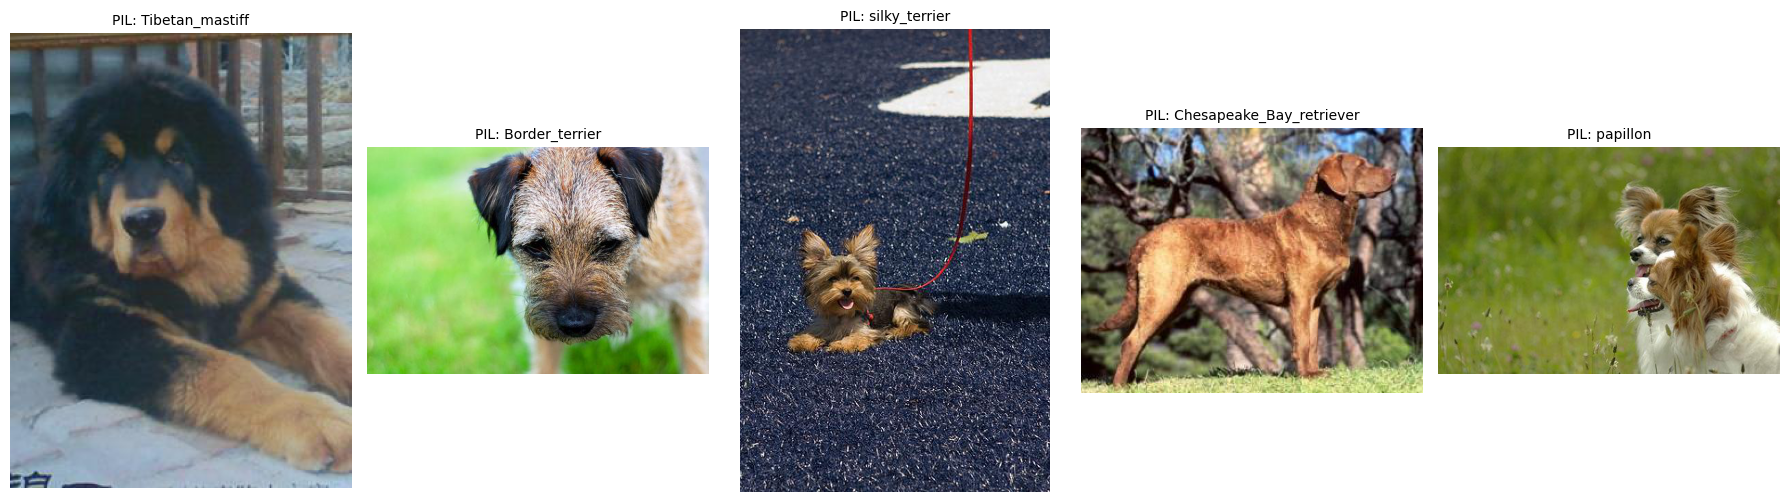

In [22]:
# 1. Raw 데이터셋 확인 (PIL 이미지)
print("Checking Raw Dataset (ds_train_raw):")
show_random_samples(ds_train_raw, class_names)

Checking Augmented Dataset (ds_aug):


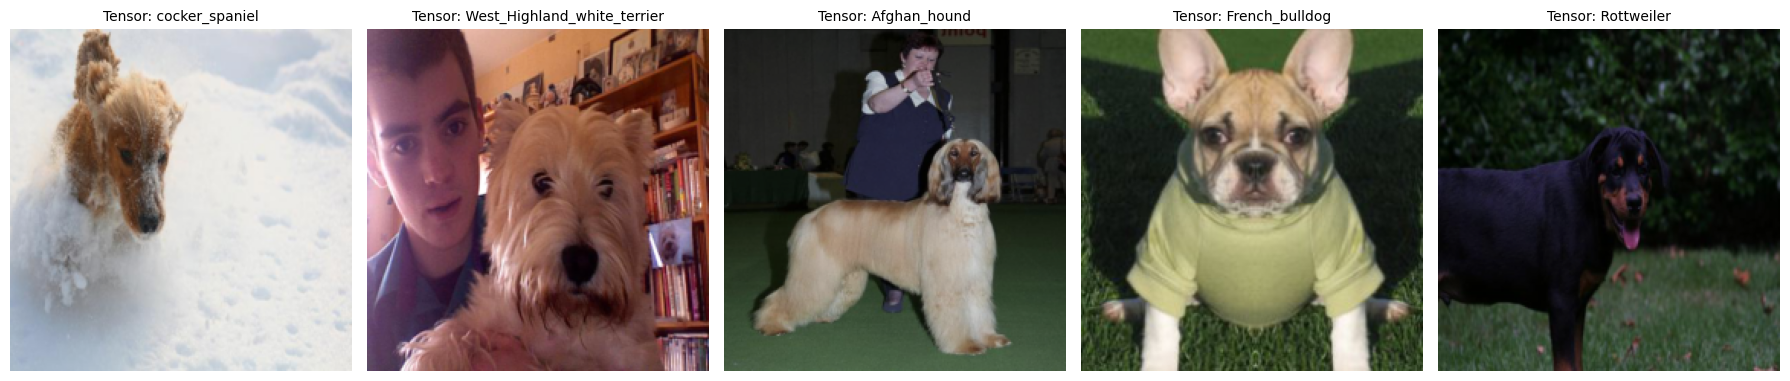

In [23]:
# 2. 증강 데이터셋 확인 (Tensor 이미지)
print("Checking Augmented Dataset (ds_aug):")
show_random_samples(ds_aug, class_names)

Checking MixUp Dataset (ds_mixup):


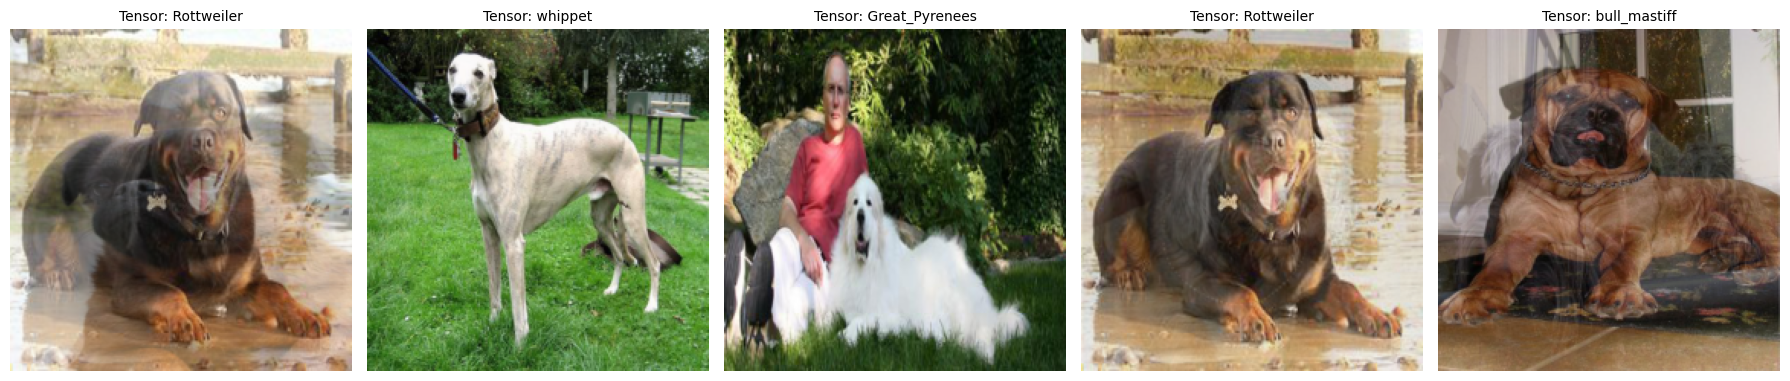

In [24]:
# 3. MixUp 데이터셋 확인 (Tensor 이미지)
print("Checking MixUp Dataset (ds_mixup):")
show_random_samples(ds_mixup, class_names)

Checking MixUp Dataset (ds_mixup):


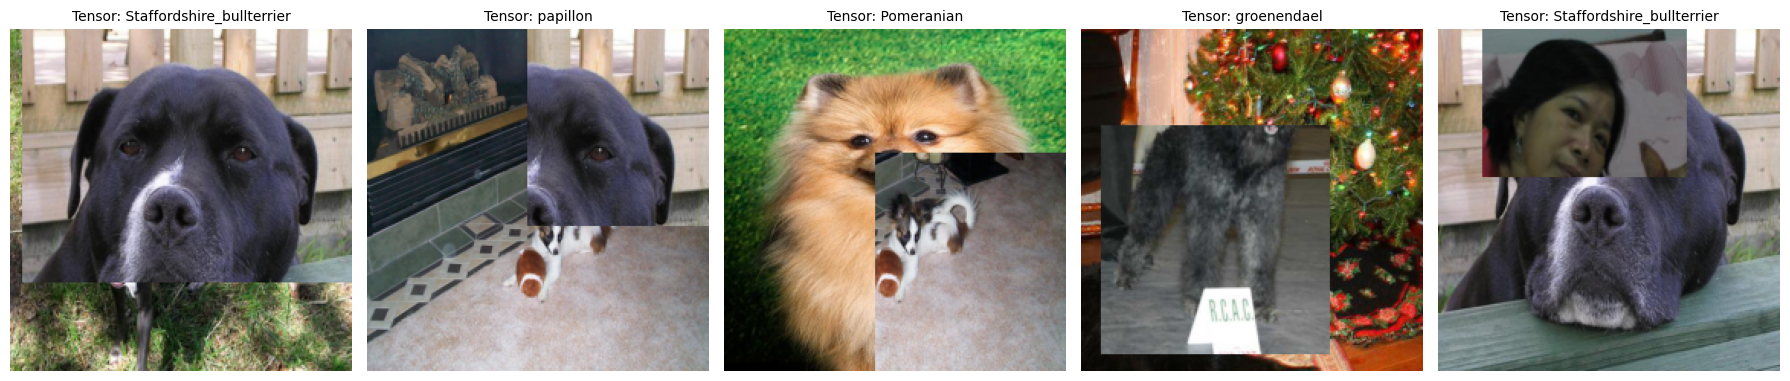

In [25]:
# 4. cutmix 데이터셋 확인 (Tensor 이미지)
print("Checking MixUp Dataset (ds_mixup):")
show_random_samples(ds_cutmix, class_names)

In [26]:
def train(model, loader, test_loader, epochs=3):
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    history = {'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)
            _, targets = labels.max(1)
            total += labels.size(0)
            correct += predicted.eq(targets).sum().item()
        
        train_acc = 100. * correct / total
        
        # Validation
        model.eval()
        v_correct, v_total = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = outputs.max(1)
                _, targets = labels.max(1)
                v_total += labels.size(0)
                v_correct += predicted.eq(targets).sum().item()
        
        val_acc = 100. * v_correct / v_total
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        print(f"Epoch {epoch+1} - Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")
    
    return history

In [27]:
# EPOCHS = 3 
EPOCHS = 20

In [28]:
print("\n--- Training: No Augmentation ---")
model_no_aug = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model_no_aug.fc = nn.Linear(model_no_aug.fc.in_features, num_classes)
hist_no_aug = train(model_no_aug, ds_no_aug, ds_test, epochs=EPOCHS)


--- Training: No Augmentation ---
Epoch 1 - Train Acc: 15.96%, Val Acc: 39.38%
Epoch 2 - Train Acc: 48.38%, Val Acc: 60.66%
Epoch 3 - Train Acc: 62.47%, Val Acc: 70.30%
Epoch 4 - Train Acc: 70.67%, Val Acc: 75.55%
Epoch 5 - Train Acc: 75.71%, Val Acc: 78.47%
Epoch 6 - Train Acc: 79.30%, Val Acc: 80.03%
Epoch 7 - Train Acc: 81.98%, Val Acc: 81.19%
Epoch 8 - Train Acc: 84.45%, Val Acc: 81.86%
Epoch 9 - Train Acc: 86.49%, Val Acc: 82.20%
Epoch 10 - Train Acc: 88.58%, Val Acc: 82.44%
Epoch 11 - Train Acc: 90.25%, Val Acc: 82.49%
Epoch 12 - Train Acc: 91.61%, Val Acc: 82.56%
Epoch 13 - Train Acc: 92.77%, Val Acc: 82.68%
Epoch 14 - Train Acc: 93.83%, Val Acc: 82.54%
Epoch 15 - Train Acc: 94.63%, Val Acc: 82.68%
Epoch 16 - Train Acc: 95.51%, Val Acc: 82.67%
Epoch 17 - Train Acc: 96.24%, Val Acc: 82.66%
Epoch 18 - Train Acc: 96.72%, Val Acc: 82.65%
Epoch 19 - Train Acc: 97.19%, Val Acc: 82.52%
Epoch 20 - Train Acc: 97.74%, Val Acc: 82.58%


In [29]:
print("\n--- Training: Basic Augmentation ---")
model_aug = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model_aug.fc = nn.Linear(model_aug.fc.in_features, num_classes)
hist_aug = train(model_aug, ds_aug, ds_test, epochs=EPOCHS)


--- Training: Basic Augmentation ---
Epoch 1 - Train Acc: 16.84%, Val Acc: 41.02%
Epoch 2 - Train Acc: 47.43%, Val Acc: 61.49%
Epoch 3 - Train Acc: 62.34%, Val Acc: 70.90%
Epoch 4 - Train Acc: 70.56%, Val Acc: 75.72%
Epoch 5 - Train Acc: 75.47%, Val Acc: 78.47%
Epoch 6 - Train Acc: 79.05%, Val Acc: 79.85%
Epoch 7 - Train Acc: 81.93%, Val Acc: 80.80%
Epoch 8 - Train Acc: 84.47%, Val Acc: 81.33%
Epoch 9 - Train Acc: 86.73%, Val Acc: 81.85%
Epoch 10 - Train Acc: 88.48%, Val Acc: 82.17%
Epoch 11 - Train Acc: 90.11%, Val Acc: 82.43%
Epoch 12 - Train Acc: 91.38%, Val Acc: 82.53%
Epoch 13 - Train Acc: 92.78%, Val Acc: 82.64%
Epoch 14 - Train Acc: 93.86%, Val Acc: 82.73%
Epoch 15 - Train Acc: 94.93%, Val Acc: 82.80%
Epoch 16 - Train Acc: 95.63%, Val Acc: 82.74%
Epoch 17 - Train Acc: 96.26%, Val Acc: 82.82%
Epoch 18 - Train Acc: 96.88%, Val Acc: 82.82%
Epoch 19 - Train Acc: 97.37%, Val Acc: 82.82%
Epoch 20 - Train Acc: 97.76%, Val Acc: 82.77%


In [30]:
print("\n--- Training: MixUp ---")
model_mixup = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model_mixup.fc = nn.Linear(model_mixup.fc.in_features, num_classes)
hist_mixup = train(model_mixup, ds_mixup, ds_test, epochs=EPOCHS)


--- Training: MixUp ---
Epoch 1 - Train Acc: 5.57%, Val Acc: 20.44%
Epoch 2 - Train Acc: 23.34%, Val Acc: 43.88%
Epoch 3 - Train Acc: 36.88%, Val Acc: 55.65%
Epoch 4 - Train Acc: 44.61%, Val Acc: 63.27%
Epoch 5 - Train Acc: 50.58%, Val Acc: 68.53%
Epoch 6 - Train Acc: 55.57%, Val Acc: 72.06%
Epoch 7 - Train Acc: 59.46%, Val Acc: 74.36%
Epoch 8 - Train Acc: 62.75%, Val Acc: 76.16%
Epoch 9 - Train Acc: 65.74%, Val Acc: 77.46%
Epoch 10 - Train Acc: 68.46%, Val Acc: 78.20%
Epoch 11 - Train Acc: 70.62%, Val Acc: 78.96%
Epoch 12 - Train Acc: 72.75%, Val Acc: 79.33%
Epoch 13 - Train Acc: 75.00%, Val Acc: 79.90%
Epoch 14 - Train Acc: 76.87%, Val Acc: 80.09%
Epoch 15 - Train Acc: 78.77%, Val Acc: 80.34%
Epoch 16 - Train Acc: 80.55%, Val Acc: 80.39%
Epoch 17 - Train Acc: 82.21%, Val Acc: 80.49%
Epoch 18 - Train Acc: 83.49%, Val Acc: 80.69%
Epoch 19 - Train Acc: 84.54%, Val Acc: 80.60%
Epoch 20 - Train Acc: 85.75%, Val Acc: 80.66%


In [32]:
print("\n--- Training: CutMix ---")
model_cutmix = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model_cutmix.fc = nn.Linear(model_cutmix.fc.in_features, num_classes)
hist_cutmix = train(model_cutmix, ds_cutmix, ds_test, epochs=EPOCHS)


--- Training: CutMix ---
Epoch 1 - Train Acc: 4.12%, Val Acc: 19.97%
Epoch 2 - Train Acc: 18.65%, Val Acc: 43.31%
Epoch 3 - Train Acc: 30.21%, Val Acc: 55.57%
Epoch 4 - Train Acc: 37.31%, Val Acc: 62.91%
Epoch 5 - Train Acc: 42.93%, Val Acc: 67.47%
Epoch 6 - Train Acc: 47.77%, Val Acc: 70.92%
Epoch 7 - Train Acc: 51.55%, Val Acc: 73.50%
Epoch 8 - Train Acc: 54.69%, Val Acc: 75.41%
Epoch 9 - Train Acc: 57.41%, Val Acc: 76.59%
Epoch 10 - Train Acc: 59.80%, Val Acc: 77.90%
Epoch 11 - Train Acc: 61.83%, Val Acc: 78.59%
Epoch 12 - Train Acc: 64.04%, Val Acc: 79.18%
Epoch 13 - Train Acc: 66.19%, Val Acc: 79.74%
Epoch 14 - Train Acc: 68.34%, Val Acc: 80.03%
Epoch 15 - Train Acc: 70.10%, Val Acc: 80.24%
Epoch 16 - Train Acc: 72.07%, Val Acc: 80.55%
Epoch 17 - Train Acc: 73.77%, Val Acc: 80.79%
Epoch 18 - Train Acc: 75.61%, Val Acc: 80.95%
Epoch 19 - Train Acc: 77.10%, Val Acc: 81.05%
Epoch 20 - Train Acc: 78.54%, Val Acc: 81.19%


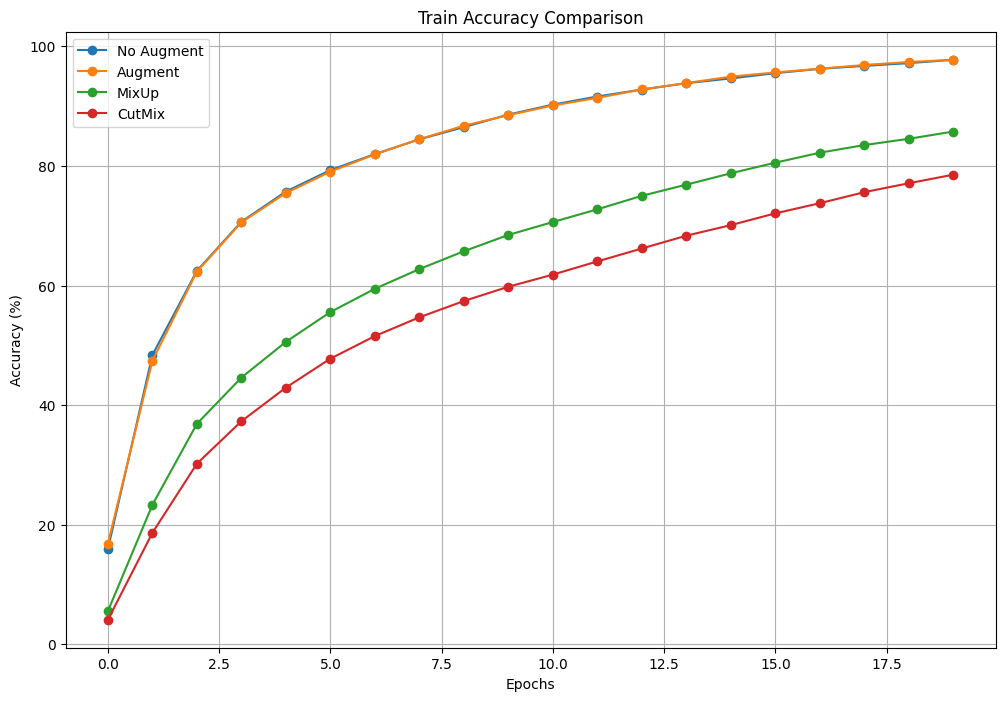

In [44]:
# 8. 결과 시각화 및 분석
plt.figure(figsize=(12, 8))
plt.plot(hist_no_aug['train_acc'], '-o',label='No Augment')
plt.plot(hist_aug['train_acc'], '-o', label='Augment')
plt.plot(hist_mixup['train_acc'], '-o',label='MixUp')
plt.plot(hist_cutmix['train_acc'], '-o', label='CutMix')
plt.title('Train Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

#### Train acc 그래프 분석
- 증강 기법 간 성능 차이: 데이터 증강을 하지 않았을 때(No Augment)와 일반적인 증강(Augment)을 적용했을 때의 훈련 정확도가 가장 높으며, 두 수치는 거의 동일하게 수렴합니다.

- 복합 증강의 영향: MixUp과 CutMix 기법을 적용한 경우, 기본 모델에 비해 훈련 정확도가 눈에 띄게 낮게 나타나는 것을 확인할 수 있습니다.

- 훈련 속도 및 난이도: MixUp과 CutMix는 모델이 학습해야 할 데이터의 복잡도를 높이기 때문에, 일반 증강에 비해 훈련 데이터에 대한 최적화 속도가 상대적으로 더딥니다.

- 전반적인 추세: 모든 기법에서 에폭(Epochs)이 진행됨에 따라 정확도는 꾸준히 상승하고 있으나, 기법별로 최종 도달하는 정확도의 상한선에는 뚜렷한 차이가 존재합니다.

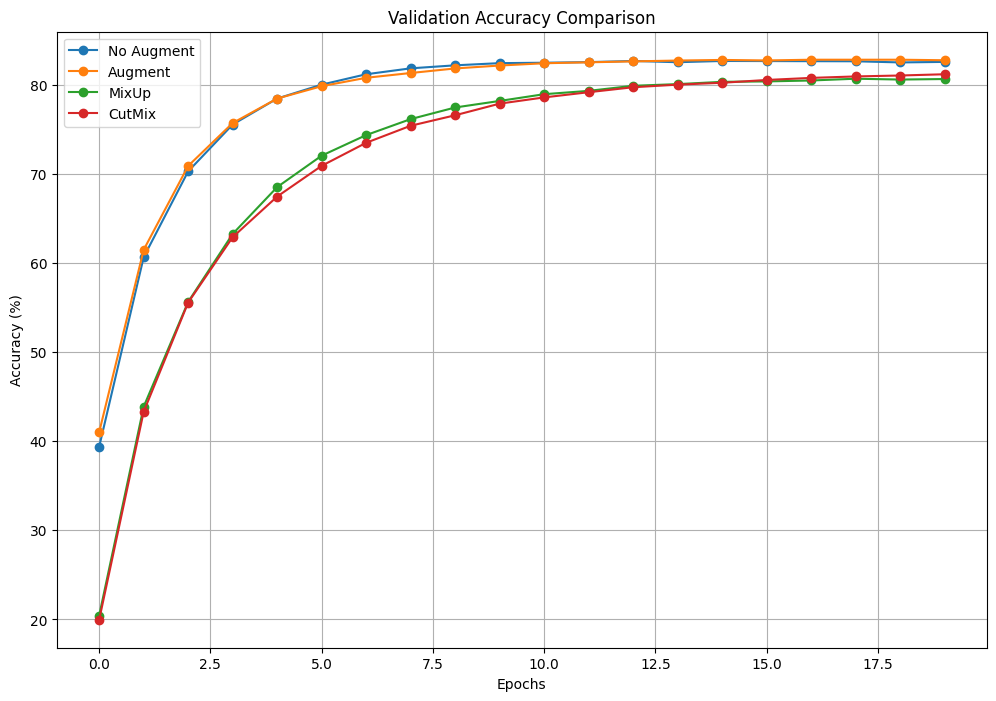

In [45]:
# 8. 결과 시각화 및 분석
plt.figure(figsize=(12, 8))
plt.plot(hist_no_aug['val_acc'],'-o', label='No Augment')
plt.plot(hist_aug['val_acc'], '-o',label='Augment')
plt.plot(hist_mixup['val_acc'], '-o',label='MixUp')
plt.plot(hist_cutmix['val_acc'],'-o', label='CutMix')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

#### Validation acc 그래프 분석
- 기법별 성능 수렴: 훈련 정확도에서 큰 차이를 보였던 것과 달리, 검증 정확도에서는 모든 기법이 최종적으로 80% 초반대 영역으로 유사하게 수렴하는 양상을 보입니다.

- 초기 학습 속도: No Augment와 Augment 방식이 초반 5에폭 이내에 빠르게 높은 정확도에 도달하며, MixUp과 CutMix는 초반 상승 속도가 상대적으로 완만합니다.

- 과대적합 억제 효과: 훈련 정확도(첫 번째 그래프)에서 100%에 육박했던 No Augment와 달리, 검증 정확도는 더 낮게 형성됨으로써 MixUp/CutMix가 일반화 성능 측면에서 격차를 줄이고 있음을 시사합니다.

- 최종 성능 역전 가능성: 그래프 후반부(15~20 에폭)를 보면 MixUp과 CutMix의 곡선이 완만하지만 꾸준히 상승하여 일반 기법들과의 격차를 거의 좁혔으며, 더 긴 학습 시 역전의 가능성도 보여줍니다.

#### 회고
dataset에 증강기법을 적용한다면 모델의 일반화 성능을 높일 수 있다는 점을 확인했습니다.  
하지만 Train acc를 보면 MixUp/CutMix 증강기법을 각각 추가한 모델이 더 낮은 모습을 확인할 수 있었으며,    
충분한 dataset을 준비하지 못한 상태로 증강기법으로 data를 늘리게 된다면 오히려 모델의 성능이 저하될 수 있다고 생각했습니다. 